In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from glob import glob
from sklearn.linear_model import LogisticRegression
from bs4 import BeautifulSoup
import cv2 as cv
from google.colab.patches import cv2_imshow as cv_imshow
from sklearn.model_selection import train_test_split
import random
from google.colab import drive
from tqdm import tqdm
import tensorflow as tf
from keras.layers import Input,Conv2D,MaxPooling2D,UpSampling2D, BatchNormalization
from keras.models import Model
from keras import optimizers
from time import time
from os.path import exists

In [ ]:
drive.mount("/content/drive/")

In [ ]:
!unzip '/content/drive/MyDrive/headsegmentation_dataset_ccncsa.zip' -d 'head_data'

In [ ]:
# Get all the paths in the dataset's directory
dir_paths = glob('/content/head_data/*')

In [ ]:
# Perform a sanity check
dir_paths[0]

'/content/head_data/malecorry_env01'

In [ ]:
# Create a set for all the unique directory identifiers (e.g. female03, male01...)
unique_dir = set([])

# Loop through all the file paths
for path in tqdm(dir_paths):

  # Divide the path between directories and subdirectories, take the last one's name
  unique_name = path.split('/')[-1]

  # Isolate the directory's unique identifier
  unique_name = unique_name.split('_')[0]

  # Add the identifier to the set
  unique_dir.add(unique_name)

100%|██████████| 80/80 [00:00<00:00, 256140.70it/s]


In [ ]:
# Remove extra identifiers which won't be used for creating the data-label pairs
for remove_dir in ['labels', 'license.txt', 'real', 'training.xml', 'male06']:
  unique_dir.remove(remove_dir)

In [ ]:
# Check the identifiers to see if there's anything extra
unique_dir

{'female03',
 'female10',
 'female23',
 'femalealison1',
 'femalealison2',
 'femalebarbera',
 'femalebarbera2',
 'femalecarla',
 'femalecarla2',
 'femalefelice',
 'femalejoyce',
 'femalejoyce2',
 'femalelaura',
 'femalelaura2',
 'femaleroberta',
 'male01',
 'male09',
 'male23',
 'maleandrew',
 'maleandrew2',
 'malebruce',
 'malebruce2',
 'malecarlos',
 'malecarlos2',
 'malecorry',
 'malecorry2',
 'maleelias',
 'maleelias2',
 'malegaberial',
 'malegaberial2',
 'malekumar',
 'maleshawn',
 'multiperson'}

In [ ]:
# Create a list to store data-label path pairs for every unique person
per_person_paired = []

# Loop through all the unique directory identifiers 
for dir in unique_dir:

  # Get all the file paths corresponding to a give identifier
  personal_paths = glob('/content/head_data/' + dir + '_*/*')

  # Generate the labels path corresponding to identifier
  generated_pairs = ['/content/head_data/labels/' + dir + '/' + path.split('/')[-1] for path in personal_paths]

  # Check if these generated paths exist
  for check_path in generated_pairs:
    if not exists(check_path):
      print(check_path)
      print('FAILED FAILED')
      break
  else:
    # Add the data-label path pairs to the list
    per_person_paired.append(dict(zip(personal_paths, generated_pairs)))
    continue
  break

In [ ]:
# Save all the pairs in a single dictionary

paired = {}

for d in per_person_paired:
  paired.update(d)

In [ ]:
# Divide the dictionary into corresponding X and y arrays
X_paths, y_paths = list(paired.keys()), list(paired.values())

In [ ]:
# Perform a sanity check that the arrays have matching paths
X_paths[0], y_paths[0]

('/content/head_data/malecorry_env01/headrende0021.png',
 '/content/head_data/labels/malecorry/headrende0021.png')

In [ ]:
# Check the shapes of images contained in the face pictures

shapes_X = []

# Loop through all the paths in X
for path in tqdm(X_paths):

  # Read the image from the path
  image = cv.imread(path)

  # Save the given shape
  shapes_X.append(image.shape)

100%|██████████| 12735/12735 [01:03<00:00, 199.29it/s]


In [ ]:
# Find all the unique shape components
np.unique(shapes_X)

array([  3, 280, 300])

In [ ]:
shapes_y = []

for path in tqdm(y_paths):

  image = cv.imread(path)

  shapes_y.append(image.shape)
  
np.unique(shapes_y)

100%|██████████| 12735/12735 [00:18<00:00, 704.15it/s]


array([  3, 280, 300])

In [ ]:
new_size = (128, 128)

# Resize the X and y images to 128, 128 for further ease of use
X = [cv.resize(cv.imread(X_path), new_size) for X_path in tqdm(X_paths)]
y = [cv.resize(cv.imread(y_path), new_size) for y_path in tqdm(y_paths)]

100%|██████████| 12735/12735 [00:16<00:00, 780.92it/s]


In [ ]:
X = np.array(X)
y = np.array(y)

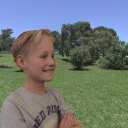

In [ ]:
# Perform another sanity check on the actual images

cv_imshow(X[0])

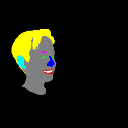

In [ ]:
cv_imshow(y[0])

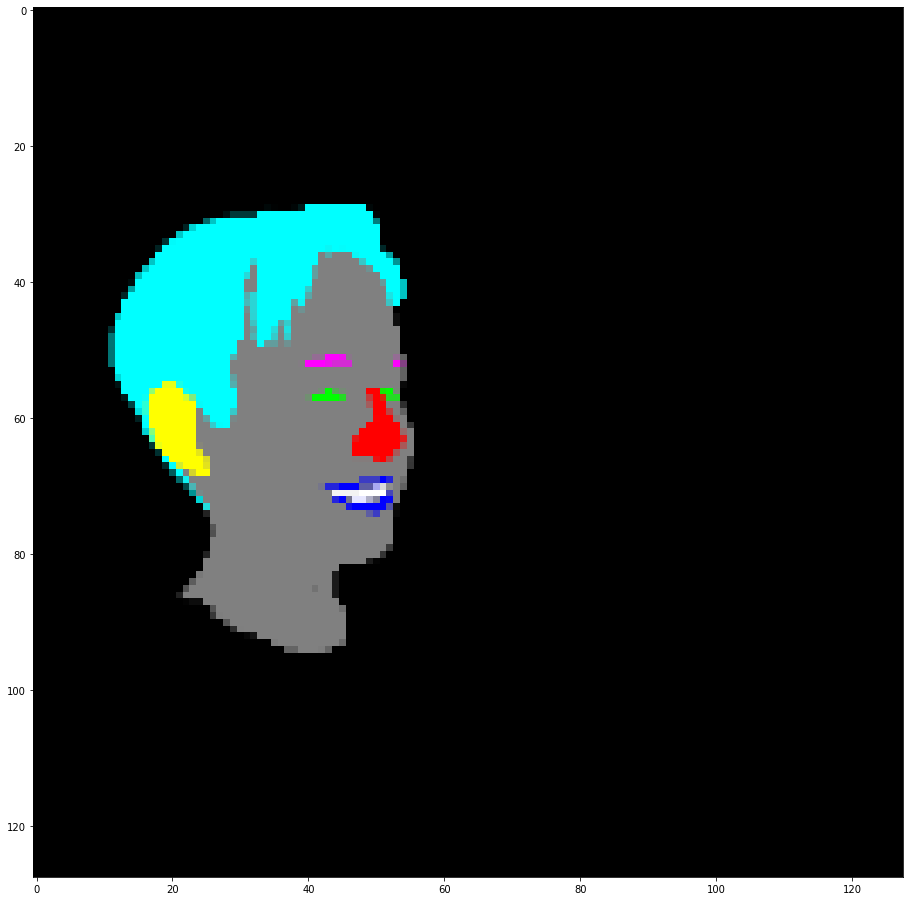

In [ ]:
plt.figure(figsize=(16, 16))
plt.imshow(y[0])

In [ ]:
# Check to see the present color values

np.unique(y[0])

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  12,  14,
        15,  17,  18,  19,  20,  21,  22,  24,  25,  26,  27,  28,  29,
        30,  32,  33,  34,  35,  36,  37,  38,  40,  42,  43,  44,  45,
        46,  47,  48,  50,  52,  53,  54,  56,  58,  60,  61,  62,  64,
        66,  70,  72,  74,  77,  78,  80,  82,  83,  86,  88,  89,  90,
        92,  93,  94,  95,  98, 100, 102, 104, 106, 107, 108, 109, 110,
       111, 112, 113, 114, 115, 116, 118, 119, 120, 121, 122, 123, 124,
       125, 126, 127, 128, 129, 130, 131, 132, 134, 135, 137, 138, 140,
       141, 143, 144, 145, 146, 147, 148, 149, 154, 156, 157, 158, 160,
       161, 162, 163, 164, 166, 167, 168, 169, 170, 173, 174, 175, 177,
       179, 182, 184, 185, 186, 191, 193, 195, 196, 197, 199, 201, 202,
       203, 205, 209, 210, 211, 212, 213, 217, 218, 219, 220, 221, 225,
       226, 228, 229, 230, 231, 233, 234, 235, 236, 237, 240, 241, 242,
       243, 245, 246, 247, 248, 250, 251, 252, 253, 254, 255], d

In [ ]:
# Define the proper labels that are defined by the dataset
proper_labels = [(0, 0, 0), (255, 0, 0), (0, 255, 0), (0, 0, 255), (128, 128, 128), (255, 255, 0), (255, 0, 255), (0, 255, 255), (255, 255, 255), (192, 192, 255), (128, 128, 0)]
proper_labels = np.array(proper_labels, dtype='float16')

In [ ]:
# Choose a pixel color threshold for classifying each pixel as one of the proper labels
threshold = 50

In [ ]:
# Flatten the labels to make further work with them easier
reshaped_y = y.reshape(-1,128*128, 3)

# Delete the original y array from memory to save RAM
del y

In [ ]:
# Perform the necessary calculations on a small batch of the data to see the final shape
reshaped_labels = proper_labels[:, None, None]
np.linalg.norm((reshaped_y[:20] -  reshaped_labels), axis=3).shape

/usr/local/lib/python3.7/dist-packages/numpy/linalg/linalg.py:2561: RuntimeWarning: overflow encountered in reduce
  return sqrt(add.reduce(s, axis=axis, keepdims=keepdims))


(11, 20, 16384)

In [ ]:
# Perform one hot encoding based on the proper labels defined by the dataset
# This step is done in this manner to conform to Google Colab's 12 GB memory limit

from time import sleep

# Create a target array to store the final results
one_hot = np.empty(shape=(11, 0, 16384), dtype='float16')

# Define the batch size for the computations
batch_number = 50

# Loop through the batches
for i in tqdm(range(12735//batch_number)):

  # Define the current batch
  batch_y = reshaped_y[i*batch_number : (i+1)*batch_number]

  # Change the batch's type to float16 to conserve memory
  batch_y = batch_y.astype(dtype='float16')

  # Take the difference between each pixel value and each proper label's value
  batch_diff = batch_y.reshape(-1, 128*128, 3) - proper_labels[:, None, None]

  # Calculate the euclidean distance between the two quantities
  batch_dist = np.linalg.norm(batch_diff, axis=3)

  # Use the threshold to finish the encoding for current batch
  batch_one_hot = batch_dist < threshold

  # Save the results into a global array
  one_hot = np.concatenate([one_hot, batch_one_hot], axis=1)

  # Delete the temporary variables from memory to conserve space
  batch_y, batch_diff, batch_dist, batch_one_hot = None, None, None, None

  # Let garbage collection work in peace once every 20 batches to avoid crashes
  if i % 20 == 0:
    sleep(10)

  0%|          | 0/254 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/numpy/linalg/linalg.py:2561: RuntimeWarning: overflow encountered in reduce
  return sqrt(add.reduce(s, axis=axis, keepdims=keepdims))
100%|██████████| 254/254 [15:15<00:00,  3.60s/it]


In [ ]:
# Repeat the steps in the previous cell, but on the final incomplete batch

sleep(15)
final_num = 12735 // batch_number

batch_y = reshaped_y[final_num*batch_number:]
batch_y = batch_y.astype(dtype='float16')
batch_diff = batch_y.reshape(-1, 128*128, 3) - proper_labels[:, None, None]
batch_dist = np.linalg.norm(batch_diff, axis=3)
batch_one_hot = batch_dist < threshold
one_hot = np.concatenate([one_hot, batch_one_hot], axis=1)

batch_y, batch_diff, batch_dist, batch_one_hot = None, None, None, None

/usr/local/lib/python3.7/dist-packages/numpy/linalg/linalg.py:2561: RuntimeWarning: overflow encountered in reduce
  return sqrt(add.reduce(s, axis=axis, keepdims=keepdims))


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Swap the first and second axis to make the dataset usable in model training
one_hot = one_hot.swapaxes(0, 1)

In [ ]:
# Save the one-hot-encoded labels
np.save('/content/drive/MyDrive/one_hot_labels.npy', one_hot)

In [ ]:
# Save the resized picture data
np.save('/content/drive/MyDrive/face_data_pics.npy', X)